In [2]:
import os
import cv2
import random
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications import MobileNetV2

In [3]:
train_dir = 'images/train'
testing_dir = 'images/testing'

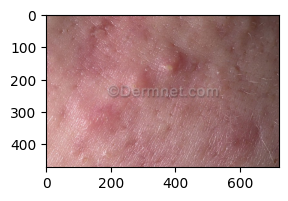

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

image = imread("images/train/acne/07AcnePittedScars.jpg")
plt.figure(figsize=(3, 3))
plt.imshow(image)


In [5]:
import skimage.io as skio
from skimage.transform import resize

IMAGE_SIZE =224
BATCH_SIZE = 128
base_dir = os.path.join('images/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    subset='validation')

X_testing = []
y_testing = []
labels = ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']

for i,label in enumerate(labels):
    folder = os.path.join("images/testing",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)


        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_testing.append(image)
        category = os.path.split(folder)[-1]
        y_testing.append(1)

X_testing = np.array(X_testing)
y_testing = np.array(y_testing)

for image_batch, label_batch in train_generator:
    break
print("dataset train:", image_batch.shape, label_batch.shape)


for image_batch, label_batch in val_generator:
    break
print("dataset train validation:", image_batch.shape, label_batch.shape)

print("dataset testing:",X_testing.shape,y_testing.shape)


Found 355 images belonging to 5 classes.
Found 85 images belonging to 5 classes.
dataset train: (128, 224, 224, 3) (128, 5)
dataset train validation: (32, 224, 224, 3) (32, 5)
dataset testing: (183, 224, 224, 3) (183,)


In [6]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt','w') as f:
     f.write(labels_txt)
        
         



{'Acne': 0, 'Actinic Keratosis': 1, 'Basal Cell Carcinoma': 2, 'Eczemaa': 3, 'Rosacea': 4}


In [7]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [8]:
base_model.trainable = False
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [9]:
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split  # (It seems like there might be a typo here too)


In [10]:
y_testing2 = to_categorical(y_testing)
X_testing3, y_testing3 = (X_testing, y_testing2)

In [11]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          589856    
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 58921669 (224.77 MB)
Trainable params: 590021 (2.25 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


In [12]:
 history = model.fit(
    train_generator,
     epochs=20,
    validation_data=val_generator,
 )

Epoch 1/20
3/3 [==============================] - 111s 33s/step - loss: 3.5726 - acc: 0.2310 - val_loss: 3.0437 - val_acc: 0.3647
Epoch 2/20
3/3 [==============================] - 75s 26s/step - loss: 1.9910 - acc: 0.5324 - val_loss: 1.9741 - val_acc: 0.4235
Epoch 3/20
3/3 [==============================] - 68s 24s/step - loss: 1.1134 - acc: 0.5831 - val_loss: 1.6925 - val_acc: 0.5059
Epoch 4/20
3/3 [==============================] - 75s 30s/step - loss: 0.9562 - acc: 0.6000 - val_loss: 1.4308 - val_acc: 0.5412
Epoch 5/20
3/3 [==============================] - 79s 30s/step - loss: 0.9030 - acc: 0.6451 - val_loss: 1.2984 - val_acc: 0.5647
Epoch 6/20
3/3 [==============================] - 67s 23s/step - loss: 0.8528 - acc: 0.6676 - val_loss: 1.2187 - val_acc: 0.5882
Epoch 7/20
3/3 [==============================] - 67s 24s/step - loss: 0.7908 - acc: 0.6958 - val_loss: 1.1500 - val_acc: 0.6118
Epoch 8/20
3/3 [==============================] - 72s 25s/step - loss: 0.7302 - acc: 0.7042 - va

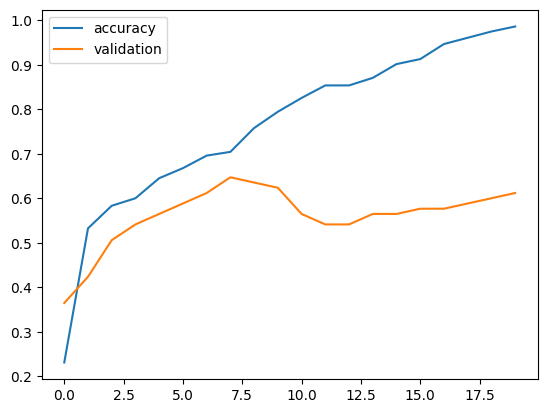

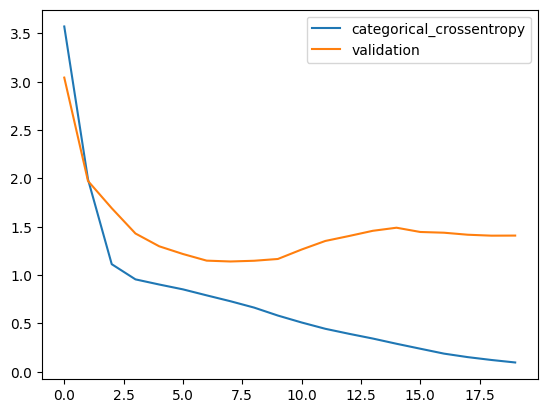

In [13]:
plt.plot(history.history["acc"],label="accuracy")
plt.plot(history.history["val_acc"],label="validation")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="categorical_crossentropy")
plt.plot(history.history["val_loss"],label="validation")
plt.legend()
plt.show()

In [14]:
print(train_generator)

In [24]:
n = 21
input_image = image_batch[n][np.newaxis,...]
print("the label is: ", label_batch[n])

predictions = model.predict(input_image)
print("the prediction is: ", predictions[0])

the label is:  [0. 0. 1. 0. 0.]
1/1 [==============================] - 1s 603ms/step
the prediction is:  [0.00703307 0.85834754 0.01162308 0.11601917 0.00697724]


In [28]:
print("Input shape of X_testing3:", X_testing3.shape)
print("Input shape of y_testing3:", y_testing3.shape)
print("Data type of X_testing3:", X_testing3.dtype)
print("Data type of y_testing3:", y_testing3.dtype)

Input shape of X_testing3: (183, 224, 224, 3)
Input shape of y_testing3: (183, 2)
Data type of X_testing3: float64
Data type of y_testing3: float32


In [35]:
print(model.metrics_names)

print(model.evaluate(x = X_testing3, y = y_testing3))

['loss', 'acc']


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Program Files\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Program Files\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ACER\AppData\Local\Temp\ipykernel_8532\763571718.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,5] labels_size=[32,2]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_30721]

In [30]:
y_true = np.argmax(y_testing2,axis=1)

y_pred = model.predict(X_testing)
y_pred = np.argmax(y_pred, axis=1)

print(y_true)
print(y_pred)

6/6 [==============================] - 51s 8s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 4 1 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 4 4 1 1 1 1 2 4 2 1 3 3 4 1 1 0 1 1 4 1 1 2 1 1 1 1 0 1 1 0 1 1 1 1 2 1
 2 2 1 3 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 4 2 4 2 1 1 2 4 4 0 3 0 1 4 2
 3 4 4 0 1 1 0 3 1 3 3 3 3 3 3 3 3 3 2 3 0 3 3 3 0 3 3 3 3 1 3 3 3 3 3 4 2
 4 4 4 0 4 0 1 4 4 4 0 4 4 4 1 4 3 4 4 4 4 4 4 4 2 4 4 3 2 3 4 4 1 1 0]


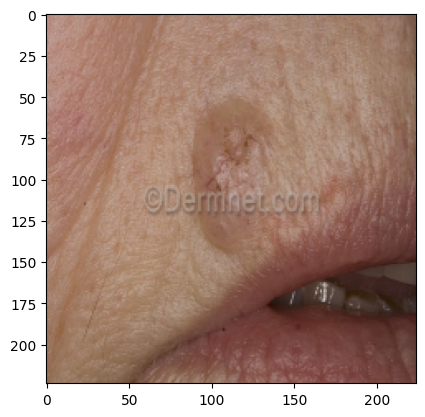

the correct label is: 1 : Actinic Keratosis
1/1 [==============================] - 1s 602ms/step
predicted value is: [0.00158467 0.4552574  0.33776456 0.00401442 0.20137894]
the predicted label is: 1 : Actinic Keratosis
prediction is correct


In [41]:
n = 100
plt.imshow(X_testing[n])
plt.show()

true_label = np.argmax(y_testing2,axis=1)[n]
print("the correct label is:",true_label,":",labels[true_label])
prediction = model.predict(X_testing[n][np.newaxis,...])[0]
print("predicted value is:",prediction)
predicted_label = np.argmax(prediction)
print("the predicted label is:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("prediction is correct")
else:
    print("wrong prediction")